In [1]:
%matplotlib inline

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [4]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import requests
import seaborn as sns

### Create a Graph from scratch

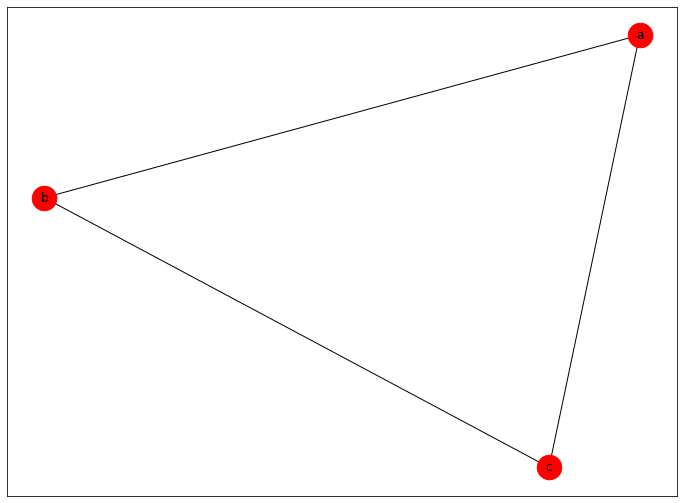

In [5]:
# Create a blank graph
g = nx.Graph()

# Insert an edge into the graph; nodes will be inserted automatically
g.add_edge('a', 'b')
g.add_edge('b', 'c')
g.add_edge('c', 'a')

# Draw the graph
fig, ax = plt.subplots(figsize=(12, 9))
nx.draw_networkx(g,  ax=ax, node_size=600, node_color='red')

In [6]:
# Nodes
g.nodes()

NodeView(('a', 'b', 'c'))

In [7]:
# Edges
g.edges()

EdgeView([('a', 'b'), ('a', 'c'), ('b', 'c')])

In [8]:
# A graph data structure in NetworkX is just like a Python dict
g.nodes['a']

g.nodes['a']['size'] = 1
g.nodes['a']

{}

{'size': 1}

In [9]:
# Nodes and edges can store arbitrary dicts of attributes, and any other type of rich data
g['a']

AtlasView({'b': {}, 'c': {}})

In [10]:
# Returns the attributes of the edge A -> B
g['a']['b']

{}

In [11]:
# sets an attribute of the edge
g['a']['b']['weight'] = 1 

g['a']['b']

{'weight': 1}

**Many of the metrics also return a dict, with node IDs as keys and metrics as values.**

## It’s dicts all the way down!

In [12]:
def read_lj_friends(g, name):
    # fetch the friend-list from LiveJournal
    response = requests.get(f"http://www.livejournal.com/misc/fdata.bml?user={name}")

    # walk through the lines in the response and add each one as an edge in a network
    for line in response.text.split("\n"):
        #Comments in the response start with a '#'
        if line.startswith('#'): continue

        # the format is "< name" (incoming) or "> name" (outgoing)
        #make sure that we don't have an empty line
        parts = line.split()
        if len(parts) == 0: 
            continue

        #add the edge to the network
        if parts[0] == '<':
            g.add_edge(parts[1], name)
        else:
            g.add_edge(name, parts[1])

In [ ]:
g = nx.Graph()
read_lj_friends(g, 'valerois')
len(g)

fig, ax = plt.subplots(figsize=(12, 9))
nx.draw_networkx(g,  ax=ax, node_size=600, node_color='red')

In [ ]:
def snowball_sampling(g, center, max_depth=1, current_depth=0, taboo_list=None):
    """
    Start with a central node
    Obtain friends of the central node
    For every one of the friends:
       sample friends of the friends
       For every friend-of-friend
           sample friends-of-friends-of-friends...
    etc...
    
    """
    if taboo_list is None:
        taboo_list = []
        
    print(center, current_depth, max_depth, taboo_list)
    if current_depth == max_depth:
        # if we have reached the depth limit of the search, return.
        print('out of depth')
        return taboo_list
    if center in taboo_list:
        #we've been here before -- return right away
        return taboo_list
    else:
        # we shall never return to the same node
        taboo_list.append(center) 

    # call LiveJournal API and get data for a node.
    read_lj_friends(g, center) 

    for node in g.neighbors(center):
        # Iterate through all friends of the central node, call snowball_sampling recursively
        taboo_list = snowball_sampling(g, node, current_depth=current_depth+1, max_depth=max_depth, taboo_list=taboo_list)
    
    return taboo_list

In [ ]:
g = nx.Graph()
snowball_sampling(g, 'kozel_na_sakse')

nx.write_pajek(g, 'lj_friends.net')

In [ ]:
nx.draw(g)

## Centrality Measures

A node degree is simply the number of connections that a node has. On Twitter, it’s the number of followers; on Facebook, it’s the number of friends; and on Reddit, it could be interpreted as the number of upvotes (“link karma”).

### Degree centrality in the LiveJournal network

In [13]:
g = nx.read_pajek('./chapter3/russians.net')
len(g)

87250

In [14]:
# compute degree
deg = g.degree

print(f"valerois degree = {deg['valerois']}")

valerois degree = 232


In [30]:
d = dict(deg)

print(f"Minimum degree {min(d.values())}")
print(f"Maximum degree {max(d.values())}")

Minimum degree 1
Maximum degree 4691


In [31]:
### This function returns a sorted degree list -- useful for celebrity-spotting
def sorted_map(dd: dict) -> dict:
    """
    Sorts dict by its values (desc)
    
    :param dd: dictionary with numeric values
    :return sorted dictionary ordered by its numeric value
    """
    sorted_dict = sorted(dd.items(), key=lambda x: (-x[1], x[0]))
    return sorted_dict

In [32]:
# get all the nodes sorted by highest degree
ds = sorted_map(d)

# let's see top 10
ds[:9]

[('borisakunin', 4691),
 ('doctor_liza', 3046),
 ('tareeva', 2970),
 ('cheger', 2887),
 ('karial', 2717),
 ('snorapp', 2707),
 ('masha_koroleva', 2683),
 ('elladkin', 2616),
 ('samoleg', 2597)]

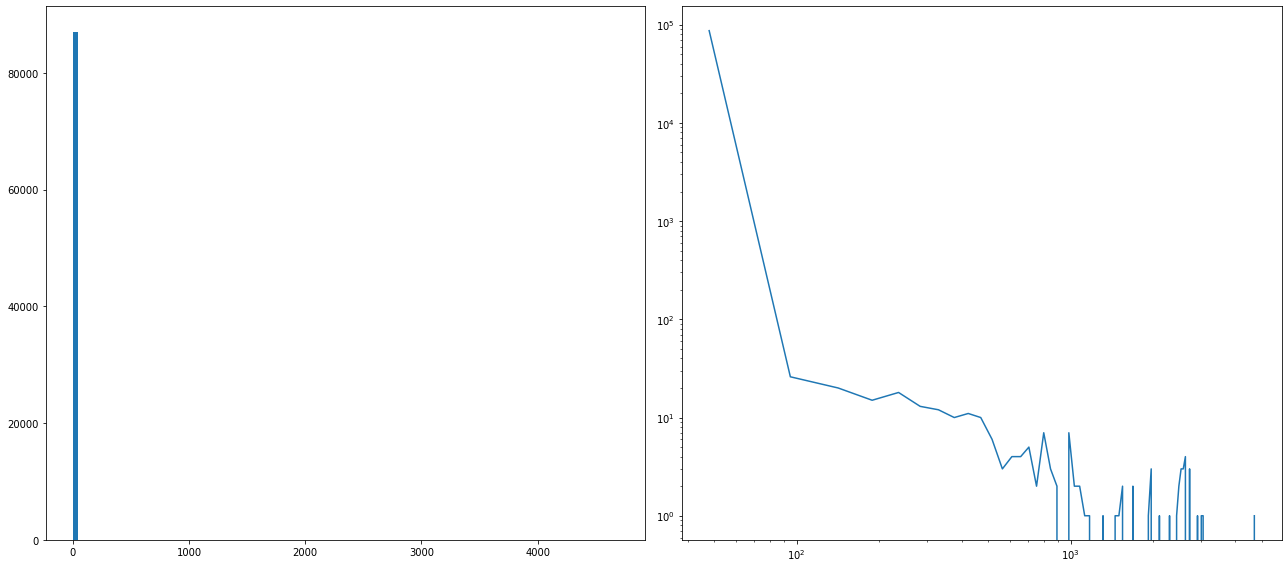

In [33]:
fig, ax = plt.subplots(1, 2, tight_layout=True, figsize=(18, 8))

# display a histogram of node degrees in 100 bins
h = ax[0].hist(d.values(), 100)

# plot the same histogram in Log-Log space
ax[1].loglog(h[1][1:], h[0])

### Closeness Centrality - The Gossipmongers

Let's trim the nodes that don't have many connections

In [19]:
def trim_degrees(g: nx.Graph, degree: int=1) -> nx.Graph:
    """
    Return a new graph object that contains the network with pendant and isolated nodes removed
    
    :param g: Graph
    :param degree: 
    """
    g2 = g.copy()
    d = g2.degree
    for n in g.nodes():
        if d[n] <= degree: 
            g2.remove_node(n)
            
    return g2

In [20]:
core = trim_degrees(g)
print(f"Number of nodes in Graph with 1 or more connections/degrees = {len(core):,}")

core2 = trim_degrees(g, degree=2)
print(f"Number of nodes in Graph with 2 or more connections/degrees = {len(core2):,}")

core3 = trim_degrees(g,degree=3)
print(f"Number of nodes in Graph with 3 or more connections/degrees = {len(core3):,}")

core10 = trim_degrees(g,degree=10)
print(f"Number of nodse in Graph with 10 or more connections/degrees = {len(core10):,}")

Number of nodes in Graph with 1 or more connections/degrees = 25,905
Number of nodes in Graph with 2 or more connections/degrees = 11,743
Number of nodes in Graph with 3 or more connections/degrees = 6,373
Number of nodse in Graph with 10 or more connections/degrees = 611


### Let's plot the last trimmed graph

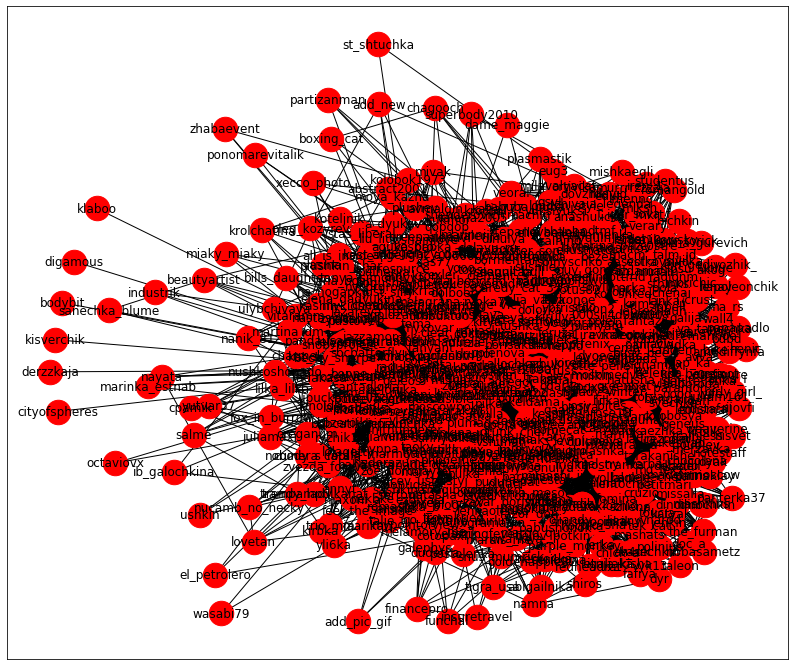

In [21]:
fig, ax = plt.subplots(figsize=(14, 12))
nx.draw_networkx(core10,  ax=ax, node_size=600, node_color='red')

### We use the core graph because calculations on the entire 81,000-node graph can take over an hour

In [22]:
c = nx.closeness_centrality(core10)

In [23]:
# Sort the results using a function from previous section
cs = sorted_map(c)

# top 10 gossipers
cs[:10]

[('azbukivedi', 0.6174089068825911),
 ('valerois', 0.6106106106106106),
 ('bagira', 0.5910852713178295),
 ('karial', 0.5749293119698398),
 ('kpoxa_e', 0.5733082706766918),
 ('yelya', 0.5374449339207048),
 ('kirulya', 0.5364995602462621),
 ('angerona', 0.5355575065847235),
 ('borisakunin', 0.5322862129144852),
 ('snorapp', 0.5304347826086957)]

### Display a histogram of closeness centrality

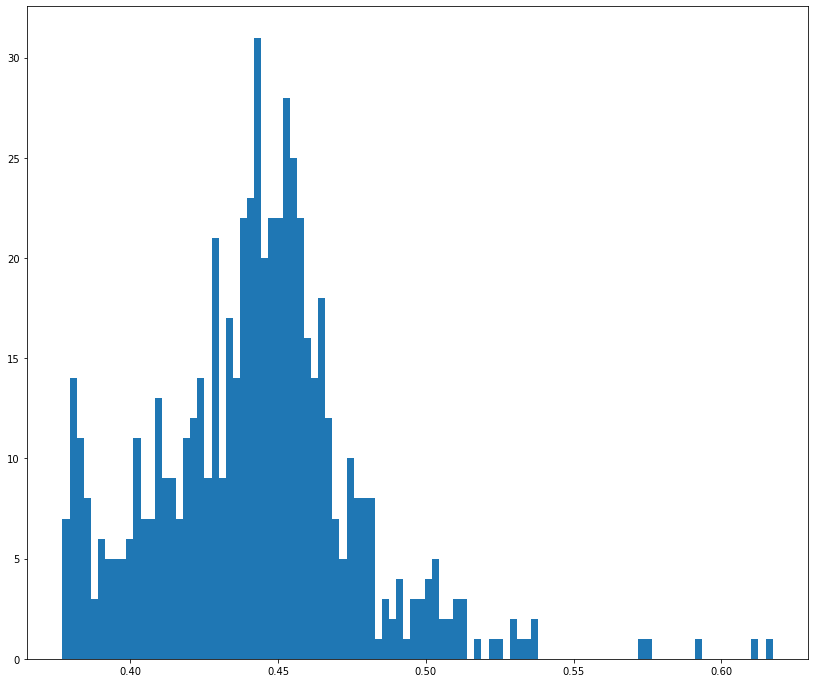

In [24]:
fig, ax = plt.subplots(figsize=(14, 12))
h = ax.hist(c.values(), 100)

### Find the Communication Bottlenecks and/or Community Bridges

Let's build a "bow" graph from a pandas DataFrame

In [25]:
df_graph = pd.DataFrame({
    'source':['D', 'D', 'D', 'D', 'D', 'D', 'A', 'A', 'B', 'G', 'G', 'E'],
    'target':['A', 'B', 'C', 'E', 'F', 'G', 'B', 'C', 'C', 'F', 'E', 'F'],
})
df_graph

source target
0       D      A
1       D      B
2       D      C
3       D      E
4       D      F
5       D      G
6       A      B
7       A      C
8       B      C
9       G      F
10      G      E
11      E      F

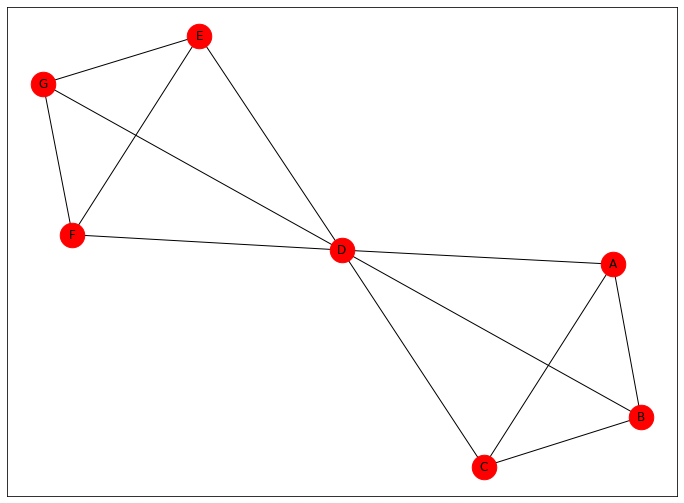

In [26]:
bow = nx.from_pandas_edgelist(df_graph, source='source', target='target', create_using=nx.Graph)
fig, ax = plt.subplots(figsize=(12, 9))
nx.draw_networkx(bow,  ax=ax, node_size=600, node_color='red')

In [28]:
# Calculate betweenes centrality
nx.betweenness_centrality(bow)

{'D': 0.6, 'A': 0.0, 'B': 0.0, 'C': 0.0, 'E': 0.0, 'F': 0.0, 'G': 0.0}

### Compute betweeness centrality in our reduced network

In [29]:
b = nx.betweenness_centrality(nx.Graph(core10))
bs = sorted_map(b)
bs[:10]

[('valerois', 0.19797072055956402),
 ('azbukivedi', 0.09236152064854664),
 ('bagira', 0.06536545576226058),
 ('karial', 0.050280309720364985),
 ('kpoxa_e', 0.0411808675767331),
 ('snorapp', 0.0266418881572934),
 ('borisakunin', 0.023414449526773046),
 ('kirulya', 0.02250083652145264),
 ('eprst2000', 0.021777315335358458),
 ('doctor_liza', 0.020776245095281833)]

|Metric |Degree|

### Make a list of the elite group by merging top ten groups for 3 centrality metrics

|Metric      |Low Degree |Low Closeness |Low Betweenness |
|------------|-----------|--------------|----------------|      
|High Degree |           |Ego is embedded in a cluster that is far from the rest of the network|Ego’s connections are redundant-the world passes him by|
|High Closeness|Key player tied to important or active others| |Ego is in a dense, active cluster at the center of events—with many others|

In [35]:
top10_names_dc = [x[0] for x in ds[:10]]
top10_names_cc = [x[0] for x in cs[:10]]
top10_names_bc = [x[0] for x in bs[:10]]

In [40]:
## use Python sets to compute a union of the sets
names = list(set(top10_names_dc) | set(top10_names_cc) | set (top10_names_bc))

## build a table with centralities
table = pd.DataFrame(
    {
        "Name": names,
        "Degree": [d[name] for name in names],
        "Closeness": [c[name] for name in names],
        "Betweenness": [b[name] for name in names]
    }, columns=["Name", "Degree", "Closeness", "Betweenness"]
)
table

Name  Degree  Closeness  Betweenness
0           cheger    2887   0.398172     0.000716
1           bagira    1481   0.591085     0.065365
2       azbukivedi    2541   0.617409     0.092362
3      doctor_liza    3046   0.481452     0.020776
4          kirulya    2398   0.536500     0.022501
5        eprst2000    2510   0.529055     0.021777
6   masha_koroleva    2683   0.495935     0.012812
7          kpoxa_e     946   0.573308     0.041181
8         angerona     752   0.535558     0.019517
9         elladkin    2616   0.464231     0.015926
10        valerois     232   0.610611     0.197971
11     borisakunin    4691   0.532286     0.023414
12         snorapp    2707   0.530435     0.026642
13           yelya     582   0.537445     0.015417
14          karial    2717   0.574929     0.050280
15         tareeva    2970   0.475448     0.005926
16         samoleg    2597   0.475078     0.015865
17    zina_korzina    2596   0.492333     0.008797

### Who Is a “Gray Cardinal?”

In [43]:
ec_numpy = nx.eigenvector_centrality_numpy(g)
sorted_map(ec_numpy)[:10]

[('borisakunin', 0.3180917047957328),
 ('azbukivedi', 0.19387462304644998),
 ('doctor_liza', 0.1650834537906371),
 ('snorapp', 0.1589026119726102),
 ('tareeva', 0.15480966173420718),
 ('bakushinskaya', 0.14843769961154527),
 ('eprst2000', 0.1475717325502641),
 ('gracebirkin', 0.1470856976093901),
 ('emmanuelle_cunt', 0.13590147650843573),
 ('karial', 0.13554190157728907)]

In [45]:
ec = nx.eigenvector_centrality(nx.Graph(g))
sorted_map(ec)[:10]

[('borisakunin', 0.31795042644649024),
 ('azbukivedi', 0.1938260892641283),
 ('doctor_liza', 0.16502760913590528),
 ('snorapp', 0.15884682173229087),
 ('tareeva', 0.15475825818165223),
 ('bakushinskaya', 0.1483965814886991),
 ('eprst2000', 0.14751796946571039),
 ('gracebirkin', 0.14704488049152348),
 ('emmanuelle_cunt', 0.1358619670502147),
 ('karial', 0.135506678927923)]

In [46]:
ec_numpy['valerois']

0.0716336892489246

### PageRank—How Google Measures Centrality

In [51]:
sorted_map(nx.pagerank_scipy(g))[:10]

[('borisakunin', 0.016397448888035807),
 ('cheger', 0.01132469218927536),
 ('a_dyukov', 0.010148368130074878),
 ('doctor_liza', 0.009861995870920017),
 ('tareeva', 0.009654198012185347),
 ('pavelrudnev', 0.009080264988425643),
 ('chagooch', 0.008652629638582859),
 ('karial', 0.008580994409528217),
 ('masha_koroleva', 0.008547980238873269),
 ('zina_korzina', 0.008495196487394564)]

In [53]:
sorted_map(nx.pagerank(nx.Graph(g)))[:10]

[('borisakunin', 0.016397448888036886),
 ('cheger', 0.011324692189276023),
 ('a_dyukov', 0.010148368130074538),
 ('doctor_liza', 0.009861995870919635),
 ('tareeva', 0.009654198012185249),
 ('pavelrudnev', 0.00908026498842542),
 ('chagooch', 0.008652629638583067),
 ('karial', 0.008580994409528342),
 ('masha_koroleva', 0.008547980238873243),
 ('zina_korzina', 0.008495196487394625)]